# Population Data Task - esure
#### By Jack Stephens
***

#### <u>Instructions</u>

Using population data from the Data tab:<br>
a) Identify top 3 countries with highest population growth from 2015 to 2019. Present graphically.<br>
b) Identify top 3 countries with highest population decline from 2010 to 2015. Present graphically.<br>
c) Forecast population of the UK and Germany for 2020-2025. Explain your approach.<br>
d) Present the population data from 2008 and 2019 in a way that it is easy for the viewer to understand the magnitudes of population across the data set.<br>
e) How did population of countries listed change from 2012 to 2013 (exclude countries with incomplete data)?
***

## 1) ETL (Extract, Transform, Load)

Firstly, we will read in the dataset and perform data-cleaning operations to wrangle the set into appropriate format.

In [107]:
import pandas as pd

pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', None, 'display.max_columns', None)

data = pd.read_excel('data/population.xlsx', sheet_name='Data', skiprows=2)

View our full dataset

In [108]:
data

,geo\time,2008,Unnamed: 2,2009,Unnamed: 4,2010,Unnamed: 6,2011,Unnamed: 8,2012,Unnamed: 10,2013,Unnamed: 12,2014,Unnamed: 14,2015,Unnamed: 16,2016,Unnamed: 18,2017,Unnamed: 20,2018,Unnamed: 22,2019,Unnamed: 24
0,EU (27 countries - from 2020),438725386,(b),440047892,NaN,440660421,(b),439942305,(b),440552661,(b),441257711,NaN,442883888,(b),443666812,(b),444802830,NaN,445534430,(b),446098424,(p),446824564,(ep)
1,EU (28 countries),500297033,(b),502090235,NaN,503170618,(b),502964837,(b),504047749,(b),505163053,NaN,507235091,(b),508520205,(b),510181874,NaN,511378572,(b),512372000,(p),513471676,(ep)
2,EU (27 countries - 2007-2013),495985066,(b),497780439,NaN,498867771,(b),498674980,(b),499771765,(b),500900913,NaN,502988282,(b),504294889,(b),505991205,NaN,507224359,(b),508266507,(p),509395430,(ep)
3,Euro area - 19 countries (from 2015),333096775,(b),334470255,NaN,335266424,NaN,334572589,(b),335288924,(b),336044966,NaN,337764352,(b),338562121,(b),339787987,NaN,340541142,(b),341145721,(p),341902187,(ep)
4,Euro area - 18 countries (2014),329884170,(b),331286399,NaN,332124448,NaN,331520001,(b),332285283,(b),333073061,NaN,334820880,(b),335640859,(b),336899429,NaN,337693238,(b),338336820,(p),339108003,(ep)
5,Belgium,10666866,NaN,10753080,NaN,10839905,NaN,11000638,(b),11075889,(b),11137974,NaN,11180840,NaN,11237274,NaN,11311117,NaN,11351727,NaN,11398589,NaN,11455519,NaN
6,Bulgaria,7518002,NaN,7467119,NaN,7421766,NaN,7369431,NaN,7327224,NaN,7284552,NaN,7245677,NaN,7202198,NaN,7153784,NaN,7101859,NaN,7050034,NaN,7000039,NaN
7,Czechia,10343422,NaN,10425783,NaN,10462088,NaN,10486731,NaN,10505445,NaN,10516125,NaN,10512419,NaN,10538275,NaN,10553843,NaN,10578820,NaN,10610055,NaN,10649800,NaN
8,Denmark,5475791,NaN,5511451,NaN,5534738,NaN,5560628,NaN,5580516,NaN,5602628,NaN,5627235,NaN,5659715,NaN,5707251,NaN,5748769,NaN,5781190,NaN,5806081,NaN
9,Germany,82217837,NaN,82002356,NaN,81802257,NaN,80222065,(b),80327900,NaN,80523746,NaN,80767463,NaN,81197537,NaN,82175684,NaN,82521653,NaN,82792351,NaN,83019213,NaN


Note the bottom rows are surplus; we therefore need to crop them

In [109]:
data = data[:-9]
data.tail()

,geo\time,2008,Unnamed: 2,2009,Unnamed: 4,2010,Unnamed: 6,2011,Unnamed: 8,2012,Unnamed: 10,2013,Unnamed: 12,2014,Unnamed: 14,2015,Unnamed: 16,2016,Unnamed: 18,2017,Unnamed: 20,2018,Unnamed: 22,2019,Unnamed: 24
50,San Marino,32054,NaN,31269,NaN,:,NaN,31863,NaN,33376,NaN,33562,NaN,32520,NaN,32789,NaN,33005,NaN,33196,NaN,34453,NaN,34590,NaN
51,Ukraine,46192309,NaN,45963359,NaN,45782592,NaN,45598179,NaN,45453282,NaN,45372692,NaN,45245894,NaN,42759661,(b),42590879,NaN,42414905,NaN,42216766,NaN,41983564,NaN
52,Armenia,3230086,NaN,3237976,NaN,3249482,NaN,3262650,NaN,3274285,NaN,3026878,NaN,:,NaN,3010598,NaN,2998577,NaN,2986151,NaN,2972732,NaN,2965269,NaN
53,Azerbaijan,8629900,NaN,8896900,NaN,8997586,NaN,9111078,NaN,9235085,NaN,9356483,NaN,9477119,NaN,9593038,NaN,9705643,NaN,9809981,NaN,9898085,NaN,9981457,NaN
54,Georgia,4382070,NaN,4385429,NaN,4436391,NaN,4469250,NaN,4497617,NaN,:,NaN,4490498,NaN,3729500,(e),3720400,NaN,3726374,NaN,3729633,NaN,3723464,NaN


Remove columns with N/A values

In [110]:
data.dropna(axis=1, inplace=True)

Let's now take a look at the columns that remain in our dataset - are they appropriately named?

In [111]:
data.columns

Index(['geo\time', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016', '2017', '2018', '2019'],
      dtype='object')

Almost! Let's just change the first column to something a bit more conventional / interpretable, such as 'Country_Region', to remove any ambiguity

In [112]:
data.rename(columns={data.columns[0]: 'Country_Region'}, inplace=True)

Now in order to attempt question a) & b), note that we will need to distinguish between country and region in the first column, as there are aggregated Euro areas included within the dataset.<br><br>
We could simply remove them; however, a cleaner, less error-prone approach would be to map the geography type to each country/region. I have done this using a fairly straightforward JSON mapping:

In [113]:
mapping = pd.read_json('mappings/area_label.json', lines=True)

print(mapping.head(10))

                                    name     type
0          EU (27 countries - from 2020)   region
1                      EU (28 countries)   region
2          EU (27 countries - 2007-2013)   region
3  Euro area - 19 countries  (from 2015)   region
4        Euro area - 18 countries (2014)   region
5                                Belgium  country
6                               Bulgaria  country
7                                Czechia  country
8                                Denmark  country
9                                Germany  country


With this, let's now create a new pandas DataFrame called 'df', that will be a merge between our dataset and the mapping table, setting the 'Country_Region' column as our index column

In [117]:
df = pd.merge(
    data,
    mapping,
    'left',
    left_on='Country_Region',
    right_on='name'
).set_index('Country_Region').drop(columns=['name'])

df

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,type
Country_Region,,,,,,,,,,,,,
EU (27 countries - from 2020),438725386,440047892,440660421,439942305,440552661,441257711,442883888,443666812,444802830,445534430,446098424,446824564,region
EU (28 countries),500297033,502090235,503170618,502964837,504047749,505163053,507235091,508520205,510181874,511378572,512372000,513471676,region
EU (27 countries - 2007-2013),495985066,497780439,498867771,498674980,499771765,500900913,502988282,504294889,505991205,507224359,508266507,509395430,region
Euro area - 19 countries (from 2015),333096775,334470255,335266424,334572589,335288924,336044966,337764352,338562121,339787987,340541142,341145721,341902187,region
Euro area - 18 countries (2014),329884170,331286399,332124448,331520001,332285283,333073061,334820880,335640859,336899429,337693238,338336820,339108003,region
Belgium,10666866,10753080,10839905,11000638,11075889,11137974,11180840,11237274,11311117,11351727,11398589,11455519,country
Bulgaria,7518002,7467119,7421766,7369431,7327224,7284552,7245677,7202198,7153784,7101859,7050034,7000039,country
Czechia,10343422,10425783,10462088,10486731,10505445,10516125,10512419,10538275,10553843,10578820,10610055,10649800,country
Denmark,5475791,5511451,5534738,5560628,5580516,5602628,5627235,5659715,5707251,5748769,5781190,5806081,country


As you can see, we now have an additional column called 'type', that tells us whether the Country_Region is either a country, such as 'Germany', or a region, such as 'EU (28 countries)'.<br><br>
We've nearly got our final, 'default' dataset ready - last thing to do is to identify those scattered colons as 'nan' data-types so that our code can interpret them properly, i.e. as numeric.

In [118]:
import numpy as np

df.replace(':', np.nan, inplace=True)

for col in df.columns[:-1]:
    df[col] = pd.to_numeric(df[col])

We'll leave it at that for now, however there may be further data handling to be performed later on.

## 2) EDA (Exploratory Data Analysis)

### a) Identify top 3 countries with highest population growth from 2015 to 2019. Present graphically.

First, we'll take a copy of our 'df' variable to ensure it remains uncorrupt for future tasks. We'll call this copy 'growth_df' and filter out the region rows so that only countries remain for analysis:

In [119]:
growth_df = df[df['type'] == 'country'].drop(columns='type')

We'll drop the 'type' column also as we no longer need it for our purposes - let's now create a new column in its place that is the calculated difference between 2019 and 2015 country populations.

In [120]:
growth_df['pop_change_2015_2019'] = growth_df['2019'] - growth_df['2015']

The question asks for just the <b>top 3</b> with the highest population <b>growth</b>, so removing nan values we get:

In [122]:
growth_df = growth_df.dropna().sort_values('pop_change_2015_2019', ascending=False).head(3)
growth_df

Plotting the data in raw format we get a line graph view per below:

<AxesSubplot:ylabel='10 Millions'>

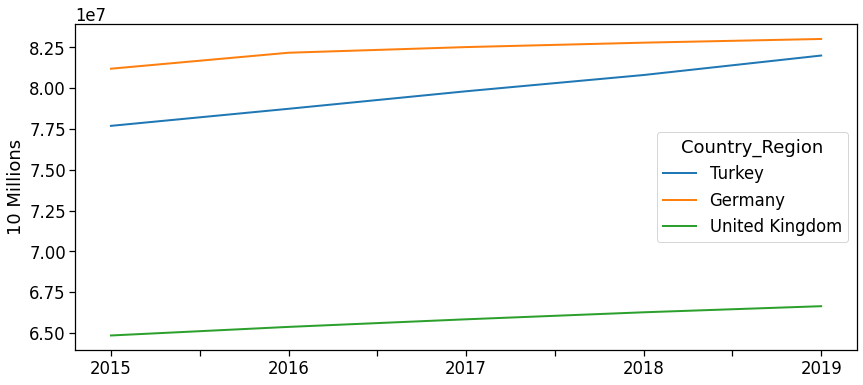

In [146]:
top_3_growth = growth_df.loc[:, '2015':'2019'].T
top_3_growth.plot(figsize=(14, 6), ylabel='10 Millions')

Let's get another angle - below is a function for a bar plot:

In [133]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [152]:
def plot_country_population_growth(df, direction):
    fig, ax = plt.subplots(figsize=(14, 5))
    sns.despine()
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})
    
    start = df['Year'].min()
    end = df['Year'].max()
    
    sns.barplot(x="Year", y="Population", data=df, hue='Country')
    ax.set_ylabel(ylabel='Population in Million', fontsize=12)
    ax.set_xlabel(xlabel='Year', fontsize=12)
    ax.set_title(f'Top 3 Highest Population {direction} {start}-{end}')
    ax.legend()

Reformat the data slightly in our 'top_3_growth' variable to get:

In [147]:
top_3_growth = top_3_growth.reset_index().rename(columns={'index': 'Year'}).melt(
    'Year',
    var_name='Country',
    value_name='Population'
)

top_3_growth

,Year,Country,Population
0,2015,Turkey,77695904.0
1,2016,Turkey,78741053.0
2,2017,Turkey,79814871.0
3,2018,Turkey,80810525.0
4,2019,Turkey,82003882.0
5,2015,Germany,81197537.0
6,2016,Germany,82175684.0
7,2017,Germany,82521653.0
8,2018,Germany,82792351.0
9,2019,Germany,83019213.0


And calling the function above, we get the following output:

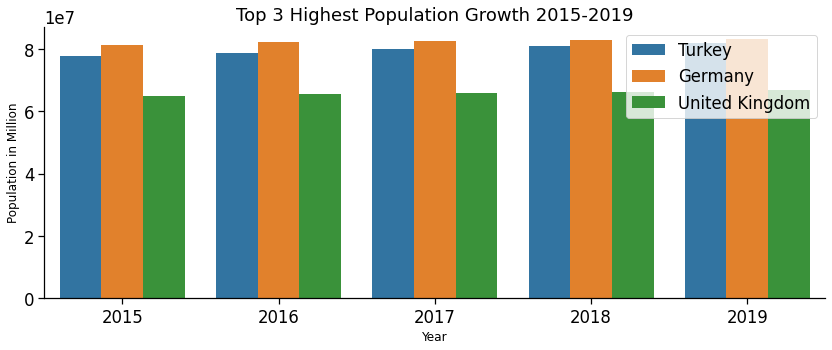

In [153]:
plot_country_population_growth(top_3_growth, 'Growth')

### b) Identify top 3 countries with highest population decline from 2010 to 2015. Present graphically.

For this question, we can largely repeat our steps from question a) and reuse the plotting function we created:

In [156]:
decline_df = df[df['type'] == 'country'].drop(columns='type')
decline_df['pop_change_2010_2015'] = decline_df['2015'] - decline_df['2010']
decline_df = decline_df.dropna().sort_values('pop_change_2010_2015').head(3)
decline_df

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,pop_change_2010_2015
Country_Region,,,,,,,,,,,,,
Ukraine,46192309.0,45963359.0,45782592.0,45598179.0,45453282.0,45372692.0,45245894.0,42759661.0,42590879.0,42414905.0,42216766.0,41983564.0,-3022931.0
Germany,82217837.0,82002356.0,81802257.0,80222065.0,80327900.0,80523746.0,80767463.0,81197537.0,82175684.0,82521653.0,82792351.0,83019213.0,-604720.0
Romania,20635460.0,20440290.0,20294683.0,20199059.0,20095996.0,20020074.0,19947311.0,19870647.0,19760585.0,19643949.0,19530631.0,19414458.0,-424036.0


<AxesSubplot:ylabel='10 Millions'>

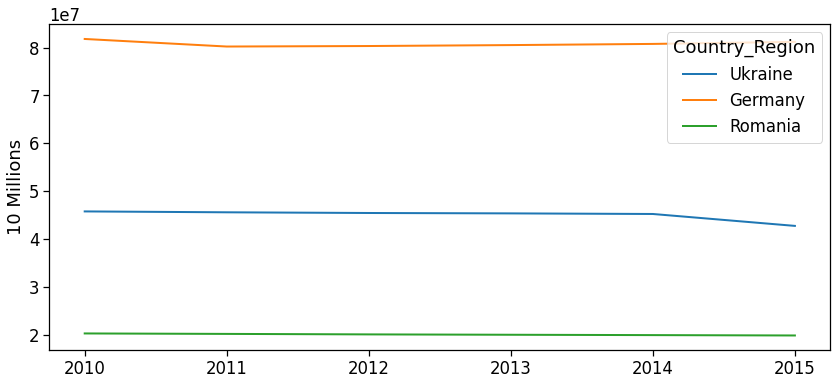

In [157]:
top_3_decline = decline_df.loc[:, '2010':'2015'].T
top_3_decline.plot(figsize=(14, 6), ylabel='10 Millions')

Reformat the data slightly in our 'top_3_growth' variable to get:

In [158]:
top_3_decline = top_3_decline.reset_index().rename(columns={'index': 'Year'}).melt(
    'Year',
    var_name='Country',
    value_name='Population'
)

top_3_decline

,Year,Country,Population
0,2010,Ukraine,45782592.0
1,2011,Ukraine,45598179.0
2,2012,Ukraine,45453282.0
3,2013,Ukraine,45372692.0
4,2014,Ukraine,45245894.0
5,2015,Ukraine,42759661.0
6,2010,Germany,81802257.0
7,2011,Germany,80222065.0
8,2012,Germany,80327900.0
9,2013,Germany,80523746.0


And calling the function above, we get the following output:

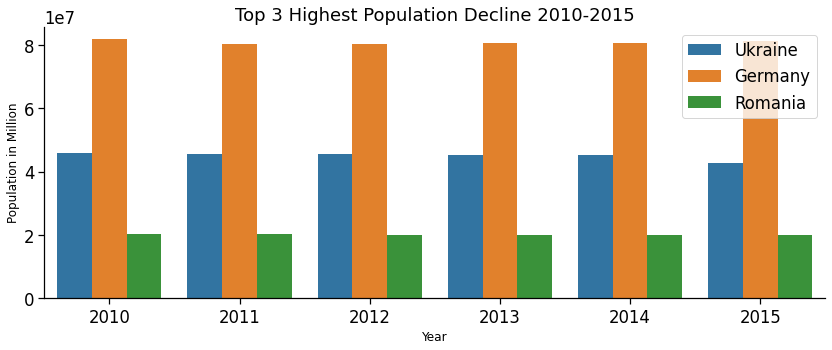

In [159]:
plot_country_population_growth(top_3_decline, 'Decline')

### c) Forecast population of the UK and Germany for 2020-2025. Explain your approach.<br>

For this question, I will use the ARIMA (Auto-Regressive Integrated Moving Average to statistically model a prediction for the populations of UK & Germany for 2020-2025.

In [160]:
uk = df[df.index == 'United Kingdom'].drop(columns=['type'])
uk

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Country_Region,,,,,,,,,,,,
United Kingdom,61571647.0,62042343.0,62510197.0,63022532.0,63495088.0,63905342.0,64351203.0,64853393.0,65379044.0,65844142.0,66273576.0,66647112.0


<AxesSubplot:ylabel='10 Millions'>

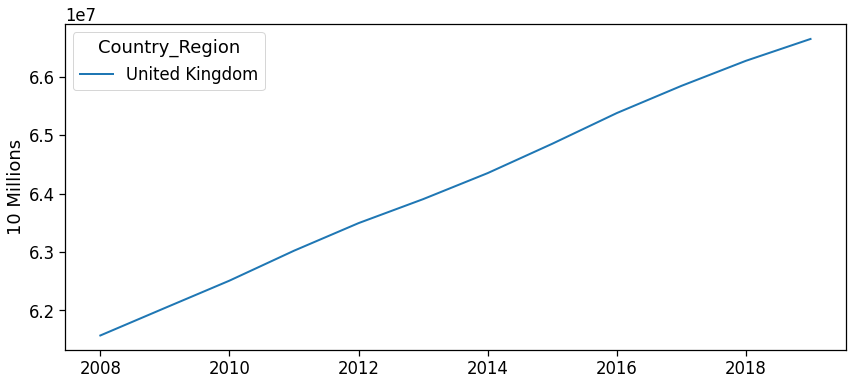

In [161]:
uk.T.plot(figsize=(14, 6), ylabel='10 Millions')

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(uk.T.values, order=(2, 1, 1))

In [41]:
model_fit = model.fit()

c:\users\user\pycharmprojects\datascience\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\user\pycharmprojects\datascience\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [42]:
predictions = model_fit.predict(len(uk.T.values), len(uk.T.values) + 5)

In [43]:
print(y_hat)

[67074483.46312579 67496137.17252697 67912173.21762234 68322666.43259068
 68727690.66432048 69127318.77583744]


In [44]:
zipped = list(zip(range(2020, 2026), y_hat))

In [45]:
for year, population in zipped:
    uk[year] = population

<AxesSubplot:>

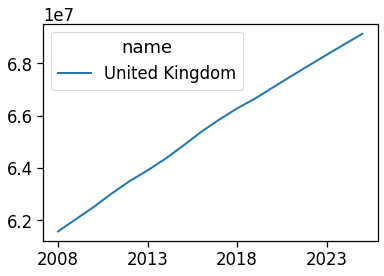

In [46]:
uk.T.plot()

In [47]:
germany = df[df.index == 'Germany'].drop(columns=['type'])

In [48]:
germany

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
name,,,,,,,,,,,,
Germany,82217837.0,82002356.0,81802257.0,80222065.0,80327900.0,80523746.0,80767463.0,81197537.0,82175684.0,82521653.0,82792351.0,83019213.0


<AxesSubplot:>

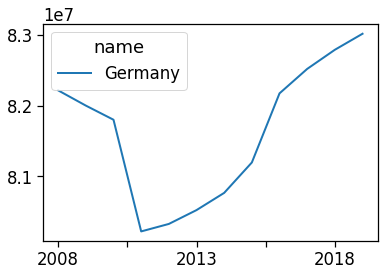

In [49]:
germany.T.plot()

In [50]:
model = ARIMA(germany.T.values, order=(1, 1, 1))

In [51]:
model_fit = model.fit()

In [52]:
y_hat = model_fit.predict(len(germany.T.values), len(germany.T.values) + 5)

In [53]:
print(y_hat)

[83010721.63348565 83005343.6353914  83001937.48592737 82999780.20472944
 82998413.89294067 82997548.54079933]


In [54]:
zipped = list(zip(range(2020, 2026), y_hat))

In [55]:
for year, population in zipped:
    germany[year] = population

<AxesSubplot:>

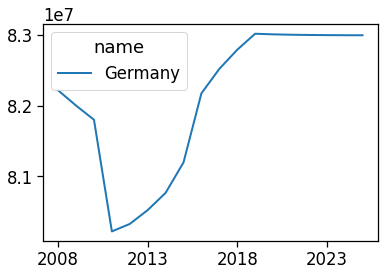

In [56]:
germany.T.plot()

In [57]:
germany

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
name,,,,,,,,,,,,,,,,,,
Germany,82217837.0,82002356.0,81802257.0,80222065.0,80327900.0,80523746.0,80767463.0,81197537.0,82175684.0,82521653.0,82792351.0,83019213.0,8.301072e+07,8.300534e+07,8.300194e+07,8.299978e+07,8.299841e+07,8.299755e+07


### d) Present the population data from 2008 and 2019 in a way that it is easy for the viewer to understand the magnitudes of population across the data set.<br>

<AxesSubplot:ylabel='name'>

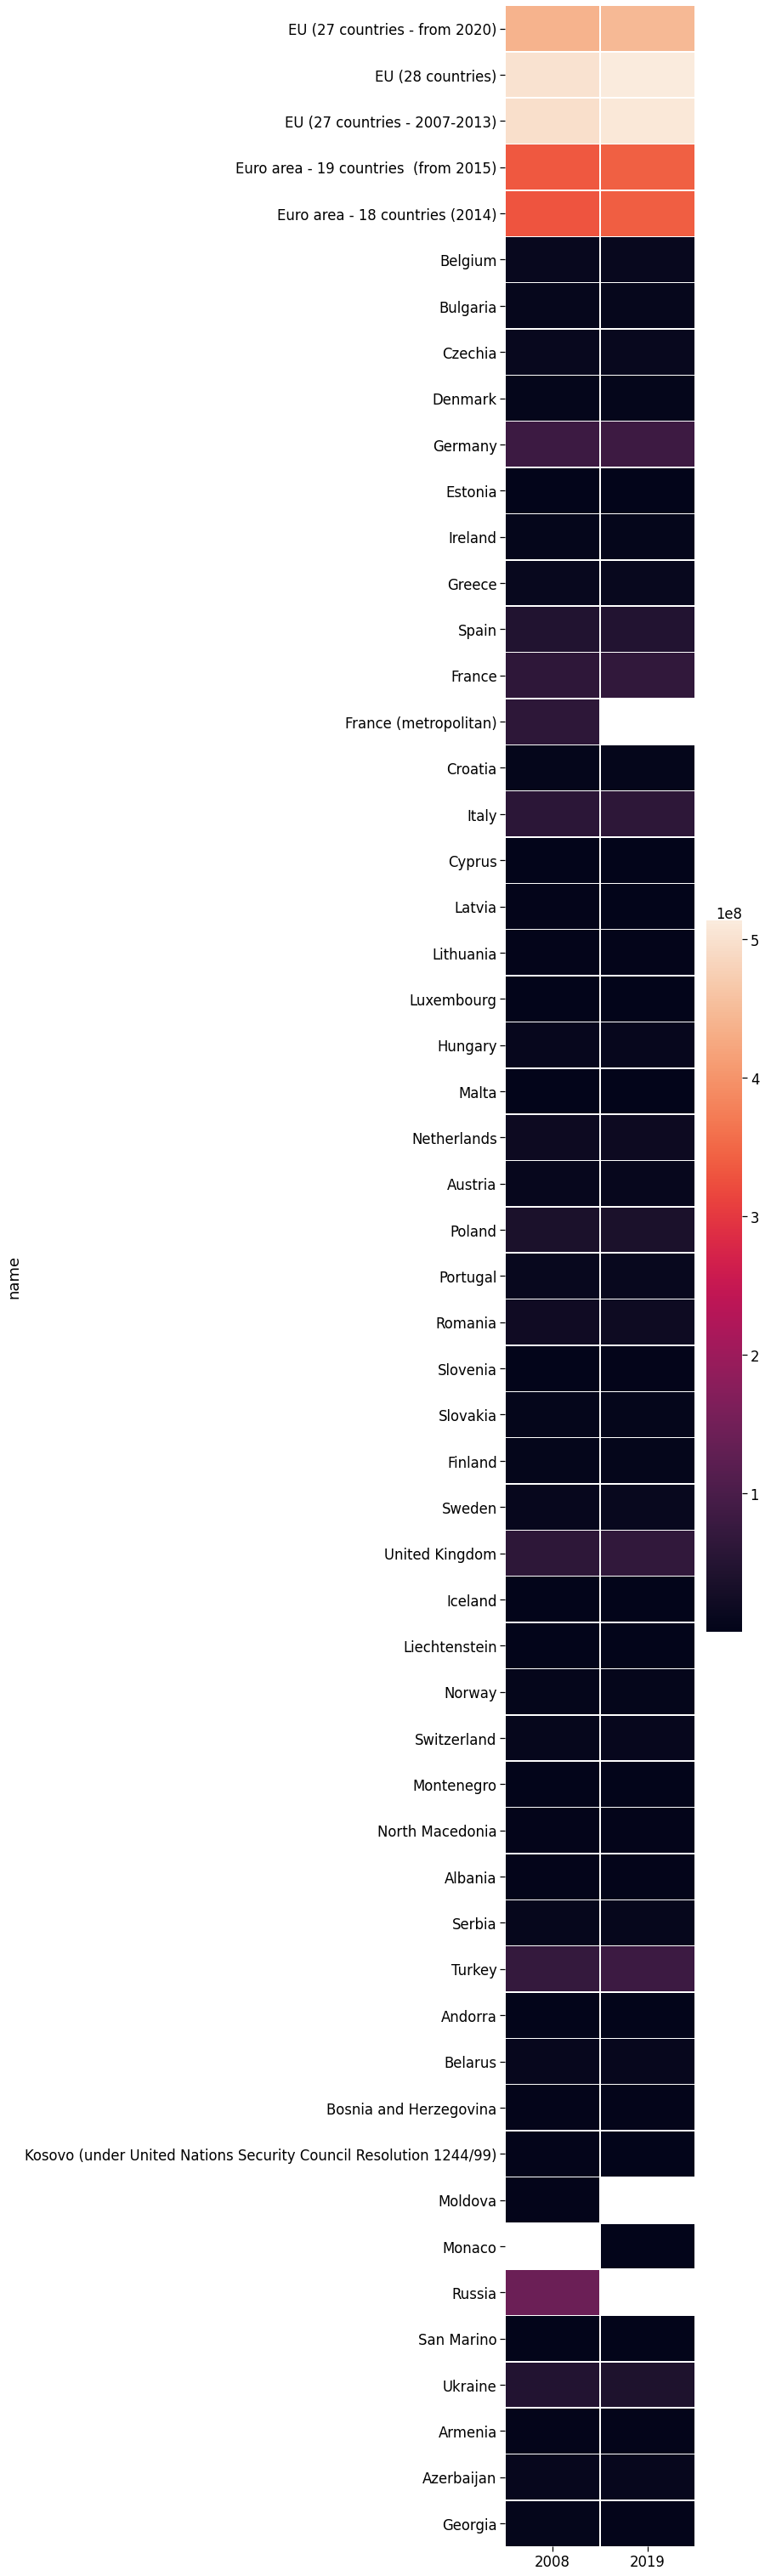

In [72]:
fig, ax = plt.subplots(figsize=(5, len(df)))
sns.heatmap(ax=ax, data=df[['2008', '2019']], linewidths=0.5)

### e) How did population of countries listed change from 2012 to 2013 (exclude countries with incomplete data)?<br>

In [81]:
countries = df[df['type'] == 'country'].dropna().drop(columns=['type'])[['2012', '2013']]

In [92]:
countries.sum()['2013']

676846195.0

In [93]:
populations = countries.sum()['2013'] - countries.sum()['2012']

In [97]:
print(f'The sum of total country populations for 2012-2013 changed by: {round(populations):,}')

The sum of total country populations for 2012-2013 changed by: 2,205,033
